# Sampling in CNID

In this tutorial, let us verify the computed CNID. 

We do this by sampling the total energy of a system of Si(111)/SiC(0001) interface with 
displacing one crystal in the CNID.

## import & prepare

In [1]:
!pip install git+https://github.com/nmdl-mizo/interface_master.git@develop
!mkdir -p cif_files
!curl https://raw.githubusercontent.com/nmdl-mizo/interface_master/develop/test_files/cif_files/Si_mp-149_conventional_standard.cif -o 'cif_files/Si_mp-149_conventional_standard.cif'
!curl https://raw.githubusercontent.com/nmdl-mizo/interface_master/develop/test_files/cif_files/SiC_mp-568656_conventional_standard.cif -o 'cif_files/SiC_mp-568656_conventional_standard.cif'

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/nmdl-mizo/interface_master.git (to revision develop) to /tmp/pip-req-build-lq_mn61j
  Running command git clone --filter=blob:none --quiet https://github.com/nmdl-mizo/interface_master.git /tmp/pip-req-build-lq_mn61j
  Resolved https://github.com/nmdl-mizo/interface_master.git to commit 2bdf96ed4835b036557ac18de82b4fa2afdabf24
  Preparing metadata (setup.py) ... done

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1059  100  1059    0     0   1312      0 --:--:-- --:--:-- --:--:--  1310
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1685  100  16

## Again, making an two-D CSL interface following the previous tutorials

In [3]:
from interfacemaster.cellcalc import get_primitive_hkl, get_pri_vec_inplane, get_normal_index
from interfacemaster.interface_generator import core, convert_vector_index, write_trans_file
from numpy import array, dot, round, cross
from numpy.linalg import inv, det
from pymatgen.core.structure import Structure

In [5]:
stct_1, stct_2 = list(map(lambda x:Structure.from_file(x), ['cif_files/Si_mp-149_conventional_standard.cif', \
                                                      'cif_files/SiC_mp-568656_conventional_standard.cif']))

/opt/anaconda3/envs/general/lib/python3.11/site-packages/pymatgen/io/cif.py:1229: UserWarning: Issues encountered while parsing CIF: 24 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [7]:
my_interface = core(stct_1,stct_2)

Warning!, this programme will rewrite the POSCAR file in this dir!


In [3]:
hkl_1 = get_primitive_hkl([1,1,1], my_interface.conv_lattice_1, my_interface.lattice_1)
hkl_2 = get_primitive_hkl([0,0,1], my_interface.conv_lattice_2, my_interface.lattice_2)

In [4]:
my_interface.parse_limit(du = 2e-2, S  = 2e-2, sgm1=50, sgm2=50, dd = 2e-2)

#Do searching!
my_interface.search_one_position_2D(hkl_1, hkl_2, theta_range = 180, \
                                    dtheta = 0.01, start = 15.21, integer_tol=1e-3)

Congrates, we found an appx CSL!

U1 = 
[[ 1 -6]
 [-6  5]
 [ 5  1]]; sigma_1 = 54

U2 = 
[[-3 -5]
 [-8  3]
 [ 0  0]]; sigma_2 = 49

D = 
[[ 0.99590432  0.00730638 -0.0032107 ]
 [-0.0032107   0.99590432  0.00730638]
 [ 0.00730638 -0.0032107   0.99590432]]

axis = [-7.47674648 -7.47674648 -7.47674648] ; theta = 15.21



In [5]:
dot(inv(my_interface.lattice_1), my_interface.CNID)

array([[ 0.06122449,  0.10204082],
       [-0.16326531,  0.06122449],
       [ 0.10204082, -0.16326531]])

In [6]:
my_interface.compute_bicrystal_two_D(hkl_1 = hkl_1, hkl_2=hkl_2, \
                                     normal_ortho = True,
                                     lim = 50, tol_ortho = 1e-2)
my_interface.get_bicrystal(two_D = True, xyz_1 = [1,1,1], xyz_2 = [1,1,1], filetype = 'LAMMPS', filename = 'atominfile', dp1 = 1.5)

cell 1:
[[-1  1 -6]
 [-1 -6  5]
 [-1  5  1]]
cell 2:
[[ 0 -3 -5]
 [ 0 -8  3]
 [-1  0  0]]


## Generate LAMMPS commands to sampling system energy in the CNID

The interface structure can be complex, especially when we can have a 'triclinic' cell.

Therefore, we provide some functions here to help you write some necessary input commands for LAMMPS.

Note that it is far more effective to do looping by LAMMPS's looping variables than by generating many different atom files!

1. Define regions & groups

In [8]:
my_interface.define_lammps_regions(['right'],[11],['EDGE'])

You can see that here we generated a 'blockfile' file defining a
'right' group, which will be displaced during the simulation.

2. Define translation variables

To verify the periodicity of CNID, we translate in a 2x2 expansion of CNID divided into a fine 50x50 grids 
(dont worry, this won't take a long time :D)

In [9]:
v1, v2 = 2*dot(my_interface.orient, my_interface.CNID).T
write_trans_file(v1,v2,50,50)

Here we generated a 'paras' file, including the looping variables and 
the translation variables which will be applied in the 'displace_atoms' command.

Now, put these two files in the 'CNID_check' folder and run LAMMPS in this folder!

After running LAMMPS, a 'results' file is generated with the energy map by RBT. Now we just show the results here.

In [10]:
from numpy import loadtxt
dx, dy, dz, energy = loadtxt('LAMMPS_input_of_CNID_cheking/results', unpack = True)

In [11]:
import matplotlib.pyplot as plt

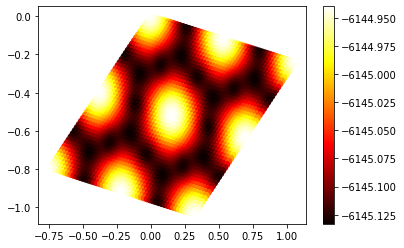

In [14]:
plt.scatter(dy, dz, c = energy, cmap = 'hot')
plt.colorbar()

A 2*2 periodicity is confirmed